In [108]:
import geopandas as gpd
from pathlib import Path
import matplotlib.pyplot as plt
import contextily as cx
import fiona 
import numpy as np
import pandas as pd
from scipy.ndimage import sobel, gaussian_filter, shift, label, morphology
# Potentiel solaire package
from potentiel_solaire.constants import DATA_FOLDER

In [3]:
# Verification des layers disponibles
stdenis_path = DATA_FOLDER / "saint_denis_reference_data.gpkg"
layers = fiona.listlayers(stdenis_path)
print(" ".join(layers))

annuaire_education bdtopo_education bdtopo_batiment cadastre_parcellaire potentielsolaire_bati potentielsolaire_toitures identifiers


## On ouvre le jeu de données préparé

In [4]:
# On ouvre une zone
ID = 8
stdenis = gpd.read_file(stdenis_path, layer="bdtopo_education")# toponymie_services_et_activites
stdenis = stdenis.to_crs(2154) # 2154 Lambert, 4326 latlon  
example = stdenis[ID:ID+1]
ID = example["cleabs_left"].iloc[0]
NOM = example["toponyme"].iloc[0]
# On ouvre les toitures
toiture = gpd.read_file(stdenis_path, layer="bdtopo_batiment")# toponymie_services_et_activites
toiture_b = gpd.read_file(stdenis_path, layer="potentielsolaire_bati")# toponymie_services_et_activites
toiture_t = gpd.read_file(stdenis_path, layer="potentielsolaire_toitures")# toponymie_services_et_activites
toiture = toiture.to_crs(2154) # 2154 Lambert, 4326 latlon  
toiture_b = toiture.to_crs(2154)
toiture_t = toiture.to_crs(2154)
toiture = gpd.sjoin(toiture, example, how='inner', predicate='intersects',lsuffix='_li', rsuffix='_ri').clip(example)
toiture_b = gpd.sjoin(toiture_b, example, how='inner', predicate='intersects',lsuffix='_li', rsuffix='_ri').clip(example)
toiture_t = gpd.sjoin(toiture_t, example, how='inner', predicate='intersects',lsuffix='_li', rsuffix='_ri').clip(example)

/home/noemiechr/13_potentiel_solaire/.venv/lib/python3.11/site-packages/contextily/tile.py:645: UserWarning: The inferred zoom level of 20 is not valid for the current tile provider (valid zooms: 0 - 19).
  warnings.warn(msg)


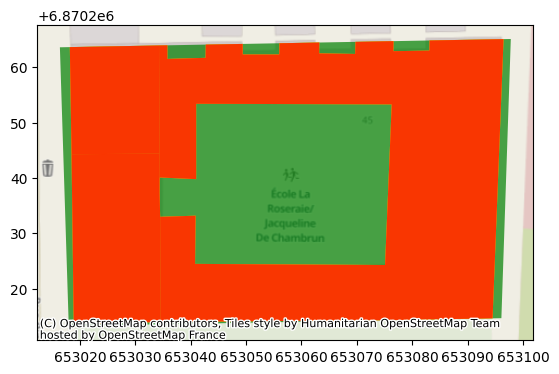

In [5]:
fig, ax = plt.subplots()

example.plot(ax=ax, alpha=0.7, color ="green")
toiture_t.plot(ax=ax, alpha=0.7, color ="yellow")
toiture_b.plot(ax=ax, alpha=0.7, color ="orange")
toiture.plot(ax=ax, alpha=0.7, color ="red")


cx.add_basemap(ax, crs=example.crs)
fig.show()

# Exploration MNS liées aux zones

In [6]:
import rasterio
import rasterio.mask
import os
from rasterio.plot import show

## On recadre l'image

In [ ]:
geotiff_cached = "../data/cache/mns/"+ID+".masked.tif"

if not os.path.isfile(geotiff_cached):
    geome = example.geometry.total_bounds
    A = "0"+str(int(geome[0]//1000))
    B = str(int(geome[1]//1000)+1)
    tile = "/MNS-Correl_1-0__TIFF_LAMB93_D093_2024-01-01/MNS-Correl/1_DONNEES_LIVRAISON_2024-11-00179/MNS-C_0M50_TIF_LAMB93_D93-2024/93-2024-"+A+"-"+B+"-LA93-0M50.tif"
    path = DATA_FOLDER / tile
    with rasterio.open("../data/"+str(path)) as img:
        out_image, out_transform = rasterio.mask.mask(img, example.geometry, crop=True)
        out_meta = img.meta
    minval = np.min(out_image[np.nonzero(out_image)])
    out_image = out_image - minval

    out_image = np.where(out_image<0, 0, out_image)
    out_meta.update({"driver": "GTiff",
                    "height": out_image.shape[1],
                    "width": out_image.shape[2],
                    "transform": out_transform})

    with rasterio.open("../data/cache/mns/"+ID+".masked.tif", "w", **out_meta) as dest:
        dest.write(out_image)

## Et on la représente

In [113]:
type(toiture_b)

geopandas.geodataframe.GeoDataFrame

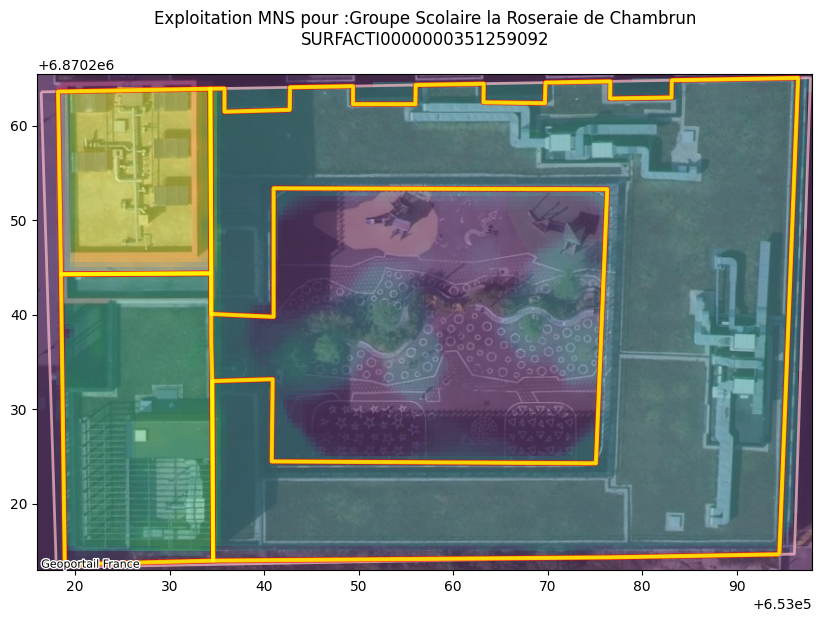

In [8]:
img_ecole = rasterio.open("../data/cache/mns/"+ID+".masked.tif")

fig, ax = plt.subplots(figsize=(10,10))



show(img_ecole, ax=ax, alpha=0.9)
example.plot(ax=ax, alpha=0.7, linewidth=2, facecolor="none", edgecolor='pink')
toiture.plot(ax=ax, alpha=0.7, linewidth=4,facecolor="none", edgecolor='red', label="batiments")
toiture_t.plot(ax=ax, alpha=0.7, linewidth=2,facecolor="none", edgecolor='orange')
toiture_b.plot(ax=ax, alpha=0.7, linewidth=3,facecolor="none", edgecolor='yellow')


cx.add_basemap(ax, crs=example.crs, alpha=0.5, source=cx.providers.GeoportailFrance.orthos )


plt.title("Exploitation MNS pour :"+ NOM+"\n"+ID+"\n")
fig.show()



# Focalisation sur les batiments

In [ ]:
geotiff_cached_toits = "../data/cache/mns/"+ID+"_toits.masked.tif"

if not os.path.isfile(geotiff_cached_toits) or True:
    geome = example.geometry.total_bounds
    A = "0"+str(int(geome[0]//1000))
    B = str(int(geome[1]//1000)+1)
    tile = "/MNS-Correl_1-0__TIFF_LAMB93_D093_2024-01-01/MNS-Correl/1_DONNEES_LIVRAISON_2024-11-00179/MNS-C_0M50_TIF_LAMB93_D93-2024/93-2024-"+A+"-"+B+"-LA93-0M50.tif"
    path = DATA_FOLDER / tile
    with rasterio.open("../data/"+str(path)) as img:
        out_image, out_transform = rasterio.mask.mask(img, toiture.geometry, crop=True)
        out_meta = img.meta
    minval = np.min(out_image[np.nonzero(out_image)])
    out_image = out_image - minval

    out_image = np.where(out_image<0, 0, out_image)

    MAX = np.percentile(out_image[np.nonzero(out_image)],80)
    out_image = np.where(out_image>=MAX, MAX, out_image)

    out_meta.update({"driver": "GTiff",
                    "height": out_image.shape[1],
                    "width": out_image.shape[2],
                    "transform": out_transform})

    with rasterio.open(geotiff_cached_toits, "w", **out_meta) as dest:
        dest.write(out_image)

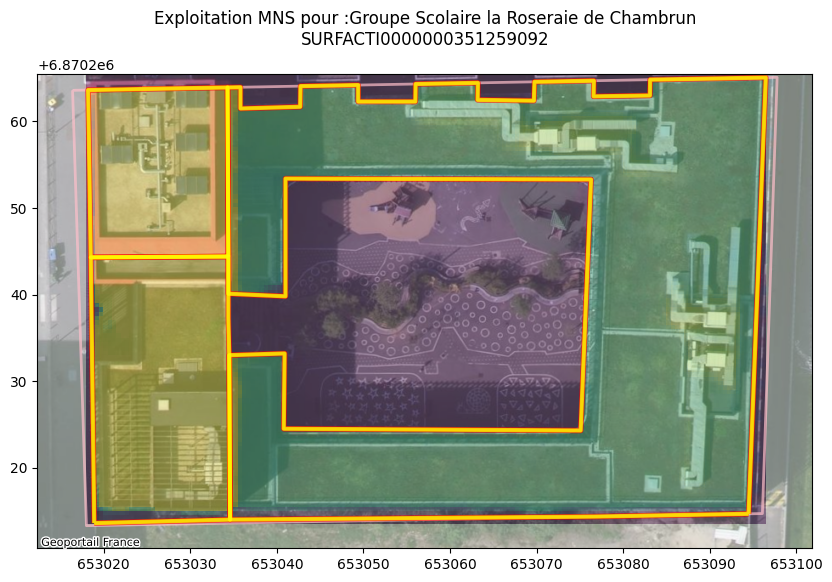

In [10]:
img_ecole = rasterio.open(geotiff_cached_toits)

fig, ax = plt.subplots(figsize=(10,10))

show(img_ecole, ax=ax, alpha=0.8)

example.plot(ax=ax, alpha=0.7, linewidth=2, facecolor="none", edgecolor='pink')
# A explorer peut etre: cx.providers.GeoportailFrance 
cx.add_basemap(ax, crs=example.crs, alpha=0.6, source=cx.providers.GeoportailFrance.orthos )
toiture.plot(ax=ax, alpha=0.7, linewidth=4,facecolor="none", edgecolor='red')
toiture_t.plot(ax=ax, alpha=0.7, linewidth=2,facecolor="none", edgecolor='orange')
toiture_b.plot(ax=ax, alpha=0.7, linewidth=3,facecolor="none", edgecolor='yellow')


plt.title("Exploitation MNS pour :"+ NOM+"\n"+ID+"\n")
fig.show()

## Analyse de la pente des toits

On plot d'abord les altitudes en appliquant un seuil pour conserver que les élements en hauteurs (toits).

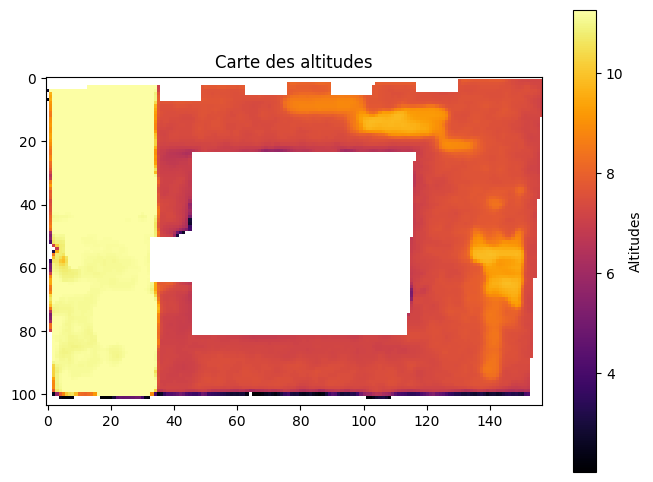

In [13]:
threshold = 2  # Seuil en mètres (à ajuster selon la donnée)
mask = out_image[0] < threshold

# Exclure ces zones du calcul de pente
focus_toits = np.where(mask, np.nan, out_image[0])


# Affichage
plt.figure(figsize=(8, 6))
cmap = plt.cm.inferno 
im = plt.imshow(focus_toits, cmap=cmap, interpolation='nearest')
cbar = plt.colorbar(im)
cbar.set_label("Altitudes")
plt.title("Carte des altitudes")
plt.show()

On calcule les dérivées partielles :

* dx représente la variation d'altitude dans la direction horizontale.
* dy représente la variation d'altitude dans la direction verticale.

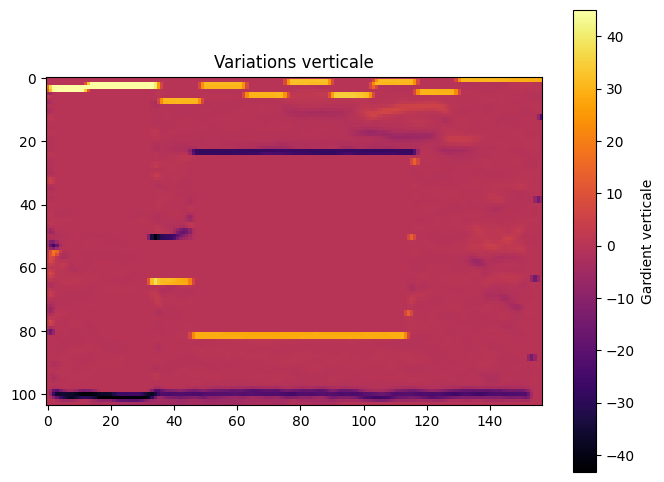

In [16]:
# Calcul des gradients X et Y
dy, dx = np.gradient(out_image[0])

dx = sobel(out_image[0], axis=1)  # Gradient selon l'axe X (est-ouest)
dy = sobel(out_image[0], axis=0)  # Gradient selon l'axe Y (nord-sud)

# Affichage des dy
plt.figure(figsize=(8, 6))
cmap = plt.cm.inferno 
im = plt.imshow(dy, cmap=cmap, interpolation='nearest')
cbar = plt.colorbar(im)
cbar.set_label("Gardient verticale")
plt.title("Variations verticale")
plt.show()

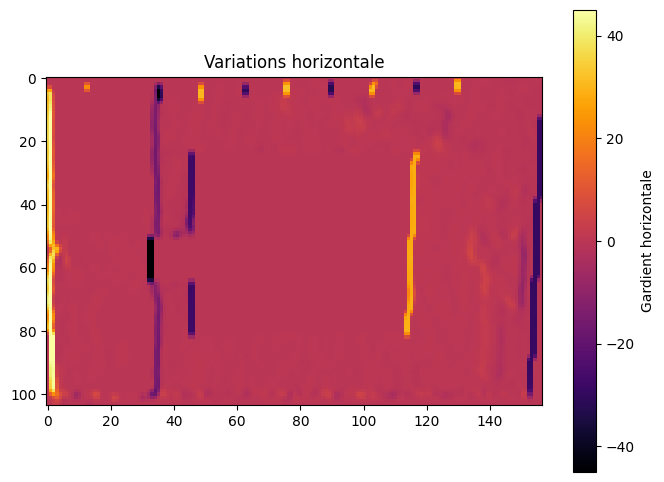

In [17]:
# Affichage des dx
plt.figure(figsize=(8, 6))
cmap = plt.cm.inferno 
im = plt.imshow(dx, cmap=cmap, interpolation='nearest')
cbar = plt.colorbar(im)
cbar.set_label("Gardient horizontale")
plt.title("Variations horizontale")
plt.show()

On calcule la norme du gradient pour calculer la pente locale.

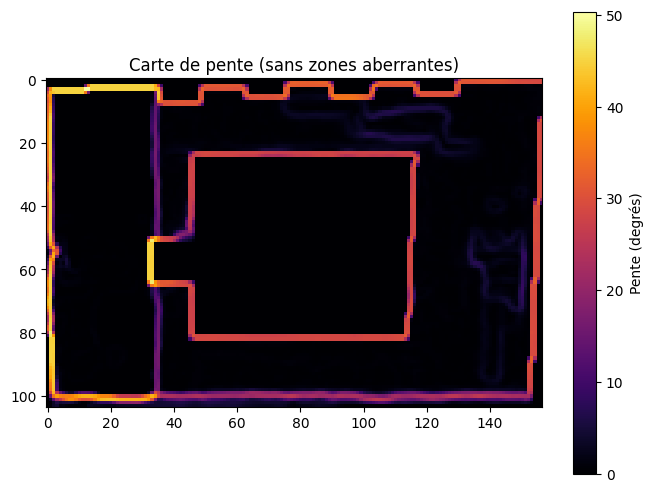

In [21]:
slope = np.sqrt(dx**2 + dy**2)

# Affichage
plt.figure(figsize=(8, 6))
cmap = plt.cm.inferno 
im = plt.imshow(slope, cmap=cmap, interpolation='nearest')
cbar = plt.colorbar(im)
cbar.set_label("Pente (degrés)")
plt.title("Carte de pente (sans zones aberrantes)")
plt.show()

On calcule l'angle à partir du gradient, puis on convertit en degré. 

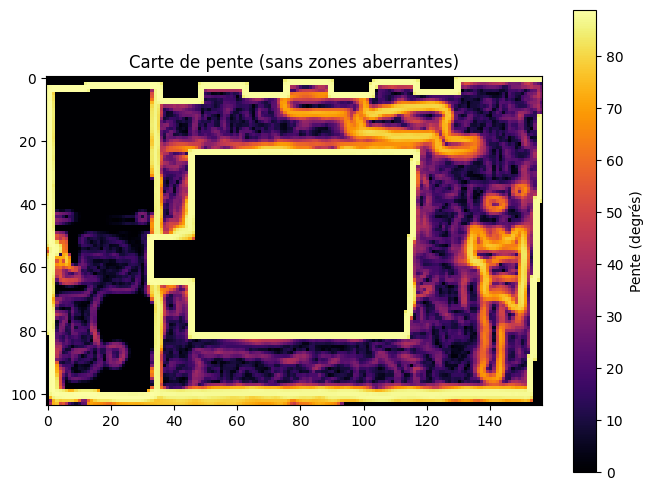

In [23]:
slope = np.arctan(np.sqrt(dx**2 + dy**2)) * (180 / np.pi)

# Affichage
plt.figure(figsize=(8, 6))
cmap = plt.cm.inferno 
im = plt.imshow(slope, cmap=cmap, interpolation='nearest')
cbar = plt.colorbar(im)
cbar.set_label("Pente (degrés)")
plt.title("Carte de pente (sans zones aberrantes)")
plt.show()

On retire les valeurs trop élevées qui correspondent à des objets sur le toit, ou aux bords des toits.

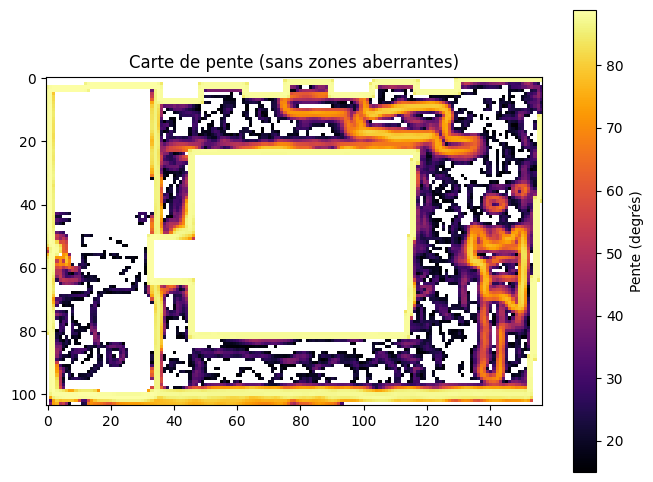

In [45]:
# Détection des zones à forte variation d'altitude
threshold = 15  # Seuil à ajuster selon la donnée)
mask = np.arctan(np.sqrt(dx**2 + dy**2)) * (180 / np.pi) < threshold

# Exclure ces zones du calcul de pente
slope_cleaned = np.where(mask, np.nan, np.arctan(np.sqrt(dx**2 + dy**2)) * (180 / np.pi))

# Affichage
plt.figure(figsize=(8, 6))
cmap = plt.cm.inferno 
im = plt.imshow(slope_cleaned, cmap=cmap, interpolation='nearest')
cbar = plt.colorbar(im)
cbar.set_label("Pente (degrés)")
plt.title("Carte de pente (sans zones aberrantes)")
plt.show()

On affiche les images de toits pour comparer avec les pentes identifiées.

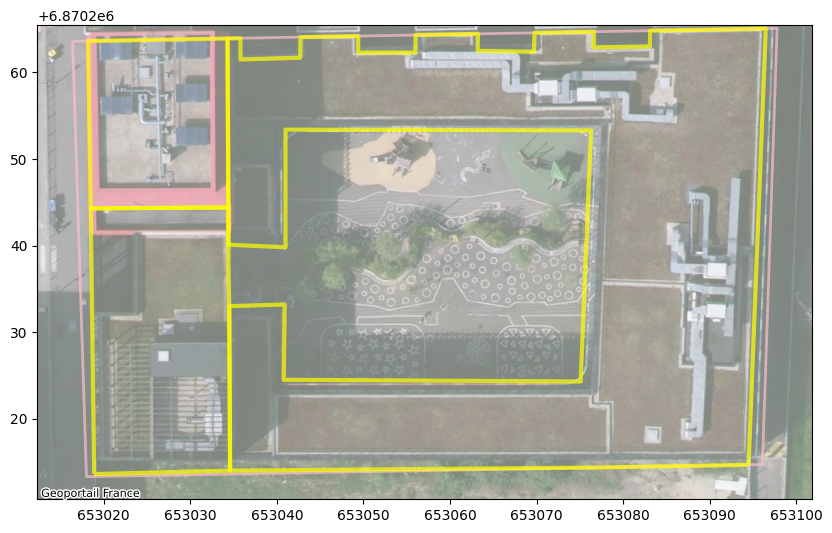

In [28]:
img_ecole = rasterio.open(geotiff_cached_toits)

fig, ax = plt.subplots(figsize=(10,10))

show(img_ecole, ax=ax, alpha=0.001)
example.plot(ax=ax, alpha=0.7, linewidth=2, facecolor="none", edgecolor='pink')
toiture_b.plot(ax=ax, alpha=0.7, linewidth=3,facecolor="none", edgecolor='yellow')
cx.add_basemap(ax, crs=example.crs, alpha=0.6, source=cx.providers.GeoportailFrance.orthos )

## Mesure de l'orientation des toits

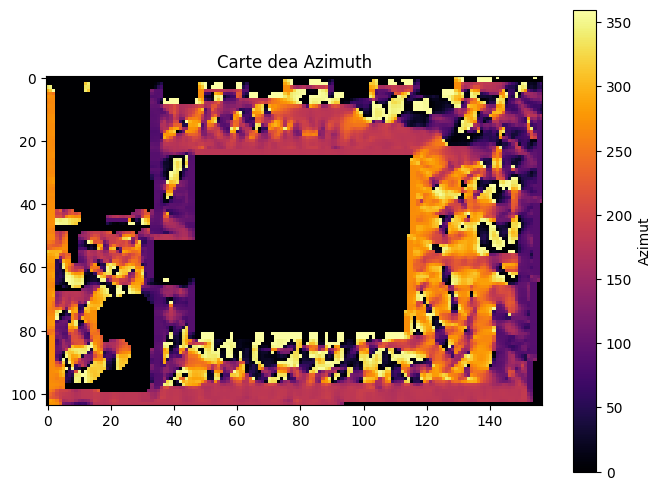

In [29]:
dx = sobel(out_image[0], axis=0)  # Dérivée selon X
dy = sobel(out_image[0], axis=1)  # Dérivée selon Y

azimut = (360 - np.degrees(np.arctan2(dy, dx))) % 360 # azimut en degré

# Affichage
plt.figure(figsize=(8, 6))
cmap = plt.cm.inferno 
im = plt.imshow(azimut, cmap=cmap, interpolation='nearest')
cbar = plt.colorbar(im)
cbar.set_label("Azimut")
plt.title("Carte dea Azimuth")
plt.show()

## Segmentation des toits

### Tests de traitements pour identifier des zones de même typologie (slope & azimut)

#### Traitement par bins

Création de bucket de valeurs pour merge les valeurs proches (approche complexe à scaler car très dépendante du bucket choisi).

Pour les azimuts : 

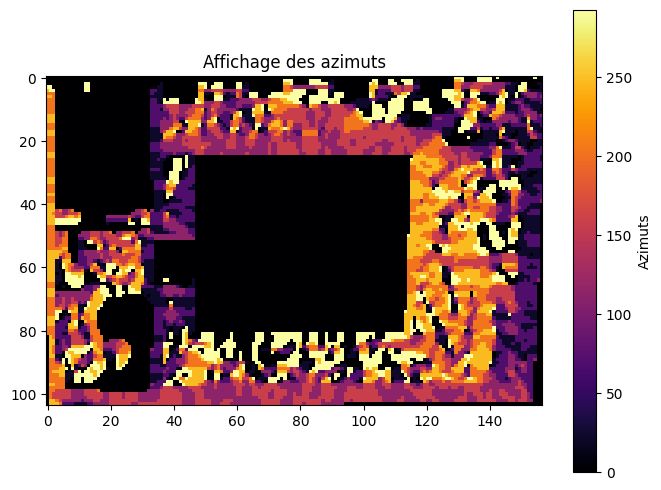

In [47]:
# Définition des intervalles et des valeurs correspondantes
bins = list(np.linspace(0,360,9))  # Délimitation des fourchettes
values = list(np.convolve(bins, [0.5, 0.5])) # Valeur à attribuer à chaque fourchette

# Transformation des valeurs
indexed = np.digitize(azimut, bins, right=False)  # Trouve l'index de la fourchette
result_azimut = np.array(values)[indexed - 1]  # Assigne la valeur correspondante
threshold_azimut = (values[-2]-values[-3]) * 1.1

# Affichage
plt.figure(figsize=(8, 6))
cmap = plt.cm.inferno 
im = plt.imshow(result_azimut, cmap=cmap, interpolation='nearest')
cbar = plt.colorbar(im)
cbar.set_label("Azimuts")
plt.title("Affichage des azimuts")
plt.show()

Pour les slopes : 

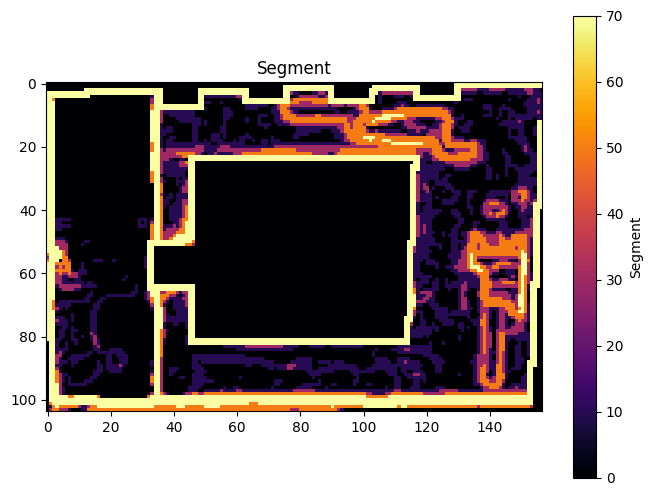

In [57]:
# Définition des intervalles et des valeurs correspondantes
bins = list(np.arange(0, slope.max(),20))  # Délimitation des fourchettes
values = list(np.convolve(bins, [0.5, 0.5])) # Valeur à attribuer à chaque fourchette

# Transformation des valeurs
indexed = np.digitize(slope, bins, right=False)  # Trouve l'index de la fourchette
result_slope = np.array(values)[indexed - 1]  # Assigne la valeur correspondante

# Affichage
plt.figure(figsize=(8, 6))
cmap = plt.cm.inferno 
im = plt.imshow(result_slope, cmap=cmap, interpolation='nearest')
cbar = plt.colorbar(im)
cbar.set_label("Segment")
plt.title("Segment")
plt.show()

#### Traitement par kernel gaussien

Test avec un Kernel gaussien pour "flouter" l'image et lisser les valeurs qui sont proches.

Pour les azimuts : 

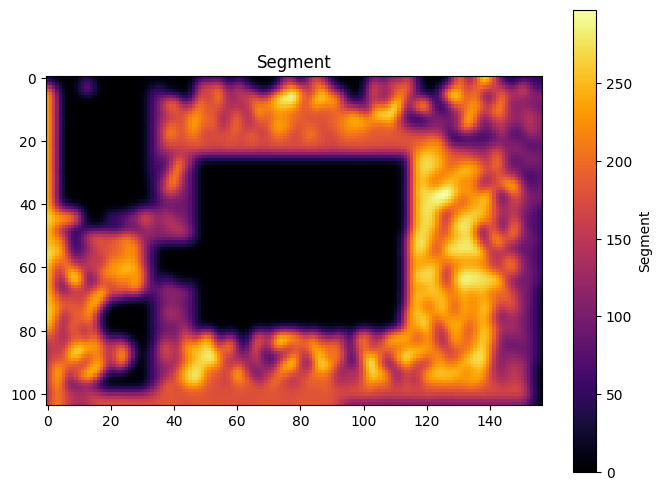

In [34]:
# Appliquer un flou gaussien avec sigma = 2
blurred_azimut = gaussian_filter(azimut, sigma=2)

# Affichage
plt.figure(figsize=(8, 6))
cmap = plt.cm.inferno 
im = plt.imshow(blurred_azimut, cmap=cmap, interpolation='nearest')
cbar = plt.colorbar(im)
cbar.set_label("Azimuts")
plt.title("Affichage des Azimuts")
plt.show()


Pour les slopes : 

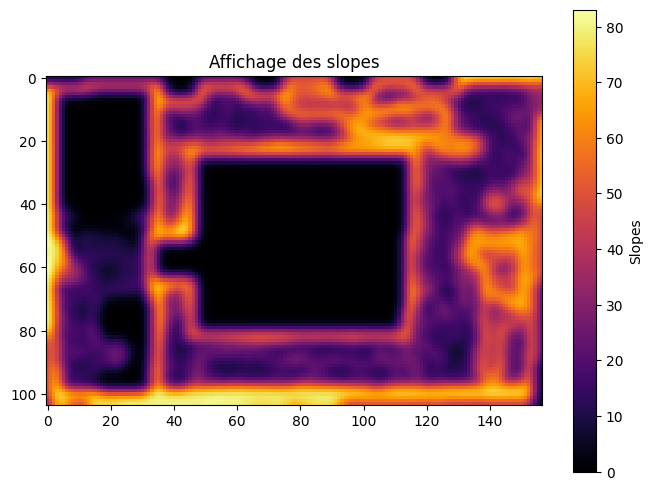

In [48]:
# Appliquer un flou gaussien avec sigma = 2
blurred_slope = gaussian_filter(slope, sigma=2)

# Affichage
plt.figure(figsize=(8, 6))
cmap = plt.cm.inferno 
im = plt.imshow(blurred_slope, cmap=cmap, interpolation='nearest')
cbar = plt.colorbar(im)
cbar.set_label("Slopes")
plt.title("Affichage des slopes")
plt.show()

### Segmentation des segments de toits

Afin de segmenter les toits, nous allons identifier les ruptures de pentes et les changements d'orientation (azimuts).

Pour cela, nous allons tout d'abord exclure les parties de toits que nous considérerons comme plates, avec des pentes inférieures à un certain seuil. Nous appliquerons le même filtre sur l'array des azimuts pour homogénéiser les résultats (sur les toits plats, le clacul de l'azimut est très instable).

In [83]:
# filtre des slopes sur les toits plats
flat_mask = result_slope < 15
result_flat = np.where(flat_mask, 0, 1)
slope_filtered = slope * result_flat

# filtre des azimut pour les toits plats
result_flat = np.where(flat_mask, 0, 1)
azimut_filtered = azimut * result_flat

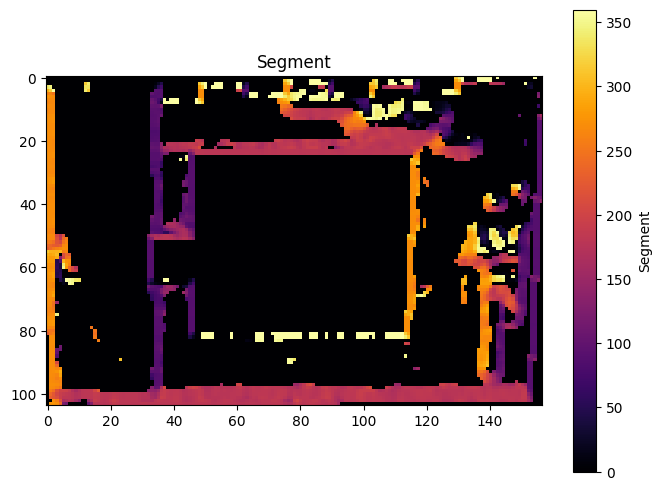

In [84]:
# Affichage
plt.figure(figsize=(8, 6))
cmap = plt.cm.inferno 
im = plt.imshow(azimut_filtered, cmap=cmap, interpolation='nearest')
cbar = plt.colorbar(im)
cbar.set_label("Segment")
plt.title("Segment")
plt.show()

Détection des frontières (là où la valeur change)

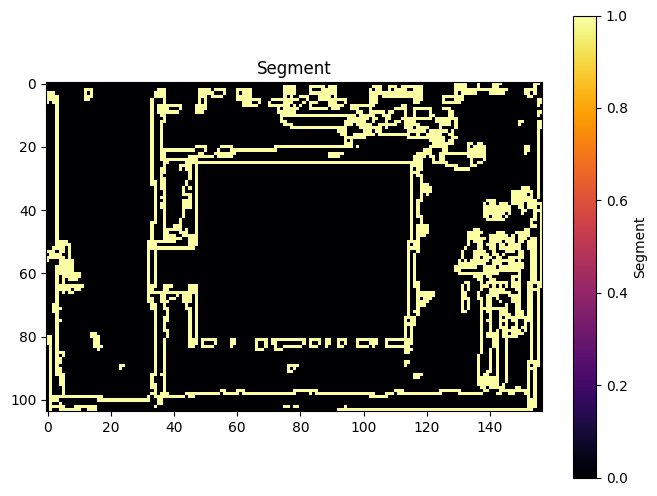

In [96]:
# Détection des frontières (là où la valeur change)
border_x = np.abs(np.diff(azimut_filtered, axis=0, prepend=azimut_filtered[0:1, :])) > 15
border_y = np.abs(np.diff(azimut_filtered, axis=1, prepend=azimut_filtered[:, 0:1])) > 15

# Création d'un masque des régions homogènes (pixels qui n'ont pas de frontière)
regions_mask = ~(border_x | border_y)

# Attribution d'un label à chaque région
azimut_bounds = np.where(regions_mask,0,1)

# Affichage
plt.figure(figsize=(8, 6))
cmap = plt.cm.inferno 
im = plt.imshow(azimut_bounds, cmap=cmap, interpolation='nearest')
cbar = plt.colorbar(im)
cbar.set_label("Segment")
plt.title("Segment")
plt.show()

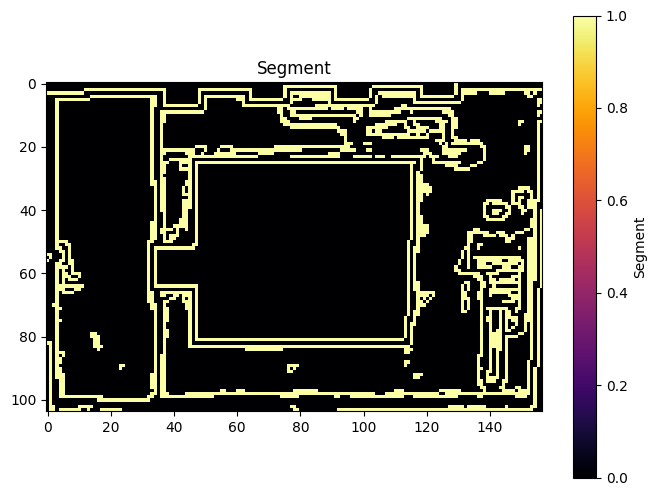

In [99]:
# Détection des frontières (là où la valeur change)
border_x = np.abs(np.diff(slope_filtered, axis=0, prepend=slope_filtered[0:1, :])) > 15
border_y = np.abs(np.diff(slope_filtered, axis=1, prepend=slope_filtered[:, 0:1])) > 15

# Création d'un masque des régions homogènes (pixels qui n'ont pas de frontière)
regions_mask = ~(border_x | border_y)

# Attribution d'un label à chaque région
slope_bounds = np.where(regions_mask,0,1)

# Affichage
plt.figure(figsize=(8, 6))
cmap = plt.cm.inferno 
im = plt.imshow(slope_bounds, cmap=cmap, interpolation='nearest')
cbar = plt.colorbar(im)
cbar.set_label("Segment")
plt.title("Segment")
plt.show()

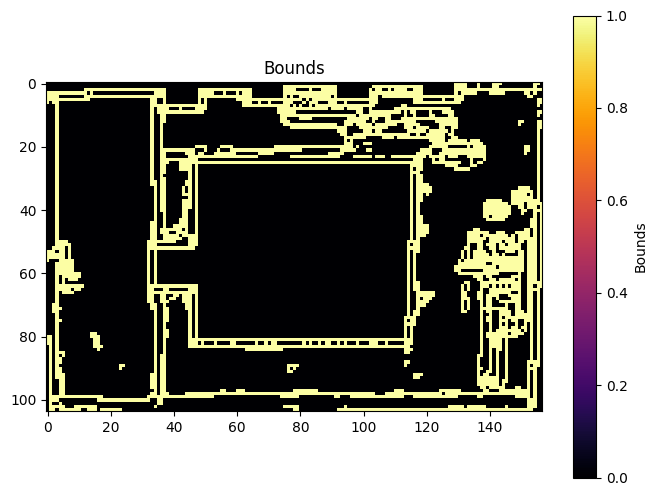

In [101]:
final_bounds = azimut_bounds + slope_bounds 
final_bounds = (final_bounds > 0).astype(int) 

# Affichage
plt.figure(figsize=(8, 6))
cmap = plt.cm.inferno 
im = plt.imshow(final_bounds, cmap=cmap, interpolation='nearest')
cbar = plt.colorbar(im)
cbar.set_label("Bounds")
plt.title("Bounds")
plt.show()

Créer des classes

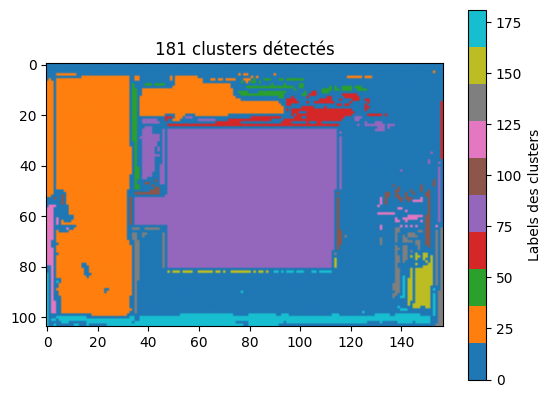

In [ ]:
# Trouver les clusters de pixels 0
labeled_bounds, num_features = label(final_bounds == 0)

# Affichage des labels
plt.imshow(labeled_bounds, cmap='tab10')
plt.colorbar(label="Labels des clusters")
plt.title(f"{num_features} clusters détectés")
plt.show()


Calcul de la pente et de l'orientation par segment de toit 

In [ ]:
df_segment_toiture = pd.DataFrame({"label":[],"surface":[],"slope":[],"azimut":[]})

for n in range(1,num_features+1) : 
    labeled_bounds_mask = labeled_bounds == n 
    slope_n = np.where(labeled_bounds_mask, slope_filtered, 0)
    azimut_n = np.where(labeled_bounds_mask, azimut_filtered, 0)
    surface_m = np.sum(labeled_bounds_mask) * 0.25
    slope_degree = np.sum(slope_n) / np.sum(labeled_bounds_mask)
    azimut_degree = np.sum(azimut_n) / np.sum(labeled_bounds_mask)
    new_row = pd.DataFrame({"label":[int(n)],"surface":[surface_m],"slope":[slope_degree],"azimut":[azimut_degree]})
    df_segment_toiture = pd.concat([df_segment_toiture,new_row])



Suppression des segments sur les bords de l'image 

**Optimisation possible en filtrant l'image à l'aide des GeoDataFrame - permet d'être plus précis et d'exclure les surfaceshors scope qui ne sont pas en bord d'image.**

In [ ]:
edge_labels = np.unique(np.concatenate([
    labeled_bounds[0, :],  # Haut
    labeled_bounds[-1, :],  # Bas
    labeled_bounds[:, 0],  # Gauche
    labeled_bounds[:, -1]  # Droite
]))

df_segment_toiture = df_segment_toiture[~df_segment_toiture["label"].isin(edge_labels)]

Filtre sur les segments avec une surface minimum 

In [110]:
# Selection de la surface minimum à considérer en m²
min_surface = 50
final_segment_toiture = df_segment_toiture[df_segment_toiture["surface"]>min_surface]
final_segment_toiture.sort_values("surface")

,label,surface,slope,azimut
0,68.0,57.50,76.29332,181.955032
0,27.0,144.25,0.00000,0.000000
0,24.0,654.75,0.00000,0.000000
0,82.0,947.75,0.00000,0.000000
